In [1]:
import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import xgboost
from dotenv import load_dotenv
from sklearn.metrics import roc_auc_score

import src.features.basic as ftr_basic
import src.models.training as train_model
import src.utils.io as io_utils
import src.visualization.plotting as visual

In [2]:
load_dotenv()
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2


ROOT = Path(os.getenv("ROOT"))
CONFIG_DIR = ROOT / Path("src/config/")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
data_cfg = io_utils.load_yaml(CONFIG_DIR / "data.yaml")
DATA_NEW_FTR = data_cfg["new_features_train_data"]

data_train = io_utils.load_df_parquet(ROOT / DATA_NEW_FTR["train_new_features_path"])
data_val = io_utils.load_df_parquet(ROOT / DATA_NEW_FTR["val_new_features_path"])

target_train = io_utils.load_df_parquet(ROOT / DATA_NEW_FTR["train_target_path"])
target_val = io_utils.load_df_parquet(ROOT / DATA_NEW_FTR["val_target_path"])

data_ids = io_utils.load_df_parquet(
    ROOT / data_cfg["origin_train_data_clean"]["ids_path"]
)

data_train.head()

,age,job,marital,education,contact,poutcome,was_contact,credit_score,job_marital,job_education,...,previous_cat,log_duration,log_balance,multiply_logs,is_overdraft,sin_month,cos_month,sin_day,cos_day,jb_mean
0,30,blue-collar,married,primary,unknown,unknown,0,1,blue-collar_married,blue-collar_primary,...,0,5.697093,7.300473,41.591476,0,0.866025,-0.500000,0.299363,-0.954139,972.500400
1,33,technician,divorced,secondary,cellular,unknown,0,0,technician_divorced,technician_secondary,...,0,6.137727,3.871201,23.760375,0,-0.500000,-0.866025,0.937752,0.347305,1073.106634
2,28,blue-collar,single,primary,telephone,unknown,0,1,blue-collar_single,blue-collar_primary,...,0,6.276643,6.318968,39.661910,0,0.866025,-0.500000,0.651372,-0.758758,972.500400
3,29,unemployed,single,primary,cellular,unknown,0,0,unemployed_single,unemployed_primary,...,0,5.468060,7.635787,41.752942,0,0.500000,0.866025,0.394356,0.918958,1429.215033
4,55,technician,married,secondary,cellular,success,1,1,technician_married,technician_secondary,...,<5,6.419995,6.763885,43.424107,0,0.500000,-0.866025,0.988468,0.151428,1073.106634


In [4]:
ftr_names = ftr_basic.get_features_names(data_train)
cat_features, num_features = ftr_names["categorical"], ftr_names["numeric"]

data_train = ftr_basic.cat_features_to_category(data_train)
data_val = ftr_basic.cat_features_to_category(data_val)

data_train, data_val = ftr_basic.align_categorical_levels(
    data_train, data_val, cat_features
)

In [5]:
cat_features

['job',
 'marital',
 'education',
 'contact',
 'poutcome',
 'job_marital',
 'job_education',
 'education_marital',
 'campaign_cat',
 'pdays_cat',
 'previous_cat']

In [7]:
model_cfg = io_utils.load_yaml(CONFIG_DIR / "models.yml")["xgboost_searh"]

PARAMS_PATH = ROOT / model_cfg["params_path"]
params = io_utils.load_yaml(PARAMS_PATH)
xgb_base_params = params["params"]
rand_search_param = params["randomized"]

xgb_base_params

{'objective': 'binary:logistic',
 'eval_metric': 'auc',
 'tree_method': 'hist',
 'enable_categorical': True,
 'random_state': 42}

In [8]:
n_iter = rand_search_param["n_iter"]
cv = rand_search_param["cv"]

n_iter, cv

(30, 5)

In [9]:
%%time

train_pool_xgb = data_train, target_train
val_pool_xgb = data_val, target_val

best_xgb = train_model.random_search_cv_xgb(
    train_pool_xgb,
    cat_features,
    xgb_base_params,
    val_pool_xgb,
    num_comb=n_iter,
    n_splits=cv,
    refit=True,
    random_seed=xgb_base_params["random_state"],
)

=============== comb params 1/30 ===============
mean auc for params: 0.9655264484740247
=============== comb params 2/30 ===============
mean auc for params: 0.9650402851562196
=============== comb params 3/30 ===============
mean auc for params: 0.9655426489884883
=============== comb params 4/30 ===============
mean auc for params: 0.9645218695430862
=============== comb params 5/30 ===============
mean auc for params: 0.965197495904848
=============== comb params 6/30 ===============
mean auc for params: 0.9639920222243287
=============== comb params 7/30 ===============
mean auc for params: 0.9641518987155768
=============== comb params 8/30 ===============
mean auc for params: 0.9646058702564305
=============== comb params 9/30 ===============
mean auc for params: 0.9652267180688352
=============== comb params 10/30 ===============
mean auc for params: 0.9641213271302863
=============== comb params 11/30 ===============
mean auc for params: 0.9651225621366539
=============== comb

In [23]:
best_xgb.save_model(ROOT / model_cfg["model_path"])

In [12]:
best_params_xgb = best_xgb.get_params()
best_iter_xgb = getattr(best_xgb, "best_iteration", None)
print("best_params: ", best_params_xgb)
print(f"best iteration: {best_iter_xgb}")

pred_best_xgb = best_xgb.predict_proba(data_val)[:, 1]
auc = roc_auc_score(target_val, pred_best_xgb)
print(f"Best XGBoost AUC: {auc:.4f}")

best_params:  {'objective': 'binary:logistic', 'eval_metric': 'auc', 'tree_method': 'hist', 'enable_categorical': True, 'random_state': 42, 'scale_pos_weight': 7.2883770960422005, 'learning_rate': 0.024897474486594344, 'max_depth': 8, 'min_child_weight': 7.792508169512386, 'subsample': 0.8994432077827796, 'colsample_bytree': 0.95631699635141, 'reg_alpha': 0.4790048592166046, 'reg_lambda': 0.11896889876122446, 'gamma': 0.008867213299758848, 'max_cat_to_onehot': 15}
best iteration: 1037
Best XGBoost AUC: 0.9662


In [13]:
meta = {
    "library": "LightGBM",
    "version": xgboost.__version__,
    "base_params": xgb_base_params,
    "best_search_params": best_params_xgb,
    "best_iteration": best_iter_xgb,
    "tree_count": best_iter_xgb + 1,
    "feature_order": list(data_train.columns),
    "categorical_features": list(cat_features),
}

io_utils.save_yaml(meta, ROOT / model_cfg["meta_path"])

In [14]:
metrics = {"auc_val": float(auc)}
preds_df = pd.DataFrame(
    {
        "val_ids": data_ids.loc[data_val.index, "id"],
        "val_preds": pred_best_xgb,
        "val_true": target_val.squeeze(),
    }
)

io_utils.save_df_parquet(preds_df, ROOT / model_cfg["preds_path"])
io_utils.save_yaml(metrics, ROOT / model_cfg["metrics_path"])

In [20]:
# best_xgb.booster._xgb_dmatrix_props = {"enable_categorical": True}

In [21]:
# getattr(best_xgb.booster, "_xgb_dmatrix_props", {})

{'enable_categorical': True}

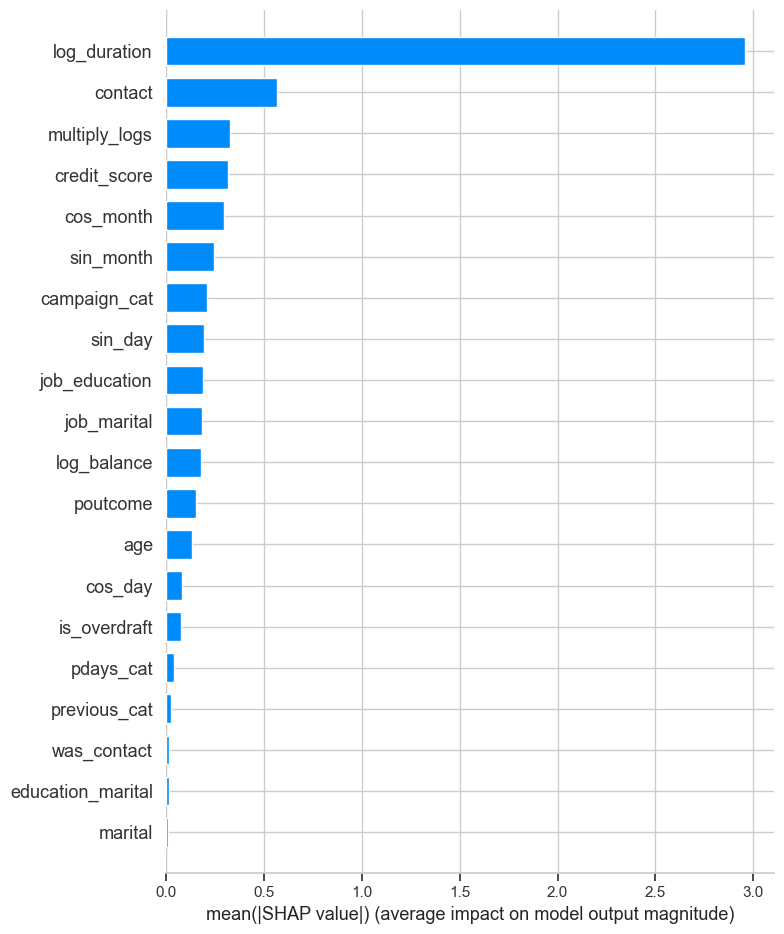

,feature,shap_value
14,log_duration,2.958617
4,contact,0.567281
16,multiply_logs,0.323837
7,credit_score,0.315935
19,cos_month,0.297593
18,sin_month,0.246244
11,campaign_cat,0.210659
20,sin_day,0.190877
9,job_education,0.187838
8,job_marital,0.181527


In [27]:
shap_values = visual.shap_values(best_xgb.booster, data_train, is_xgb=True)

shap_values

In [25]:
import xgboost as xgb

test_params_xgb = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
    "enable_categorical": True,
    "seed": 42,
    "scale_pos_weight": 7.2883770960422005,
    "learning_rate": 0.007453933493768898,
    "max_depth": 6,
    "min_child_weight": 1.6990806380564423,
    "subsample": 0.6149650224704719,
    "colsample_bytree": 0.8219409877565933,
    "reg_alpha": 0.012964830748893102,
    "reg_lambda": 2.085254046019693,
    "gamma": 0.2659220904665465,
    "max_cat_to_onehot": 14,
}


dtrain = xgb.DMatrix(data_train, label=target_train, enable_categorical=True)
dval = xgb.DMatrix(data_val, label=target_val, enable_categorical=True)

# 4) Тренировка с ранней остановкой
booster = xgb.train(
    params=test_params_xgb,
    dtrain=dtrain,
    num_boost_round=10000,
    evals=[(dval, "val")],
    early_stopping_rounds=200,
    verbose_eval=False,
)

In [26]:
# 5) Предсказание на лучшей итерации + AUC
# try:
pred_xgb = booster.predict(dval, iteration_range=(0, booster.best_iteration + 1))
# except TypeError:
#     pred_xgb = booster.predict(dval, ntree_limit=booster.best_iteration + 1)

val_auc = roc_auc_score(target_val, pred_xgb)
print(f"VAL AUC: {val_auc:.6f}")

VAL AUC: 0.965626
